In [1]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
from time import time
# import dill
import pickle
import glob
import importlib
import numpy as np
import scipy as sp
import scipy.misc
import pandas as pd
import re
import itertools
from scanf import scanf
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from matplotlib import colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm, PowerNorm, Normalize
from mpl_toolkits.mplot3d import axes3d, Axes3D
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate, optimize, sparse
from scipy.interpolate import interp1d, interp2d
from IPython.display import display, HTML, Math
from scipy import interpolate
from tqdm.notebook import tqdm as tqdm_notebook

from src import slenderBodyTheory as slb
from src.geo import *
from src.objComposite import *
from codeStore import support_fun as spf
from codeStore.support_fun_head_tail import *
from codeStore.support_fun_tail_rotate import *

PWD = os.getcwd()
np.set_printoptions(linewidth=110, precision=5)

params = {'animation.html': 'html5',
          'font.family':    'sans-serif',
          'font.size':      15, }
preamble = r' '
preamble = preamble + '\\usepackage{bm} '
preamble = preamble + '\\usepackage{amsmath} '
preamble = preamble + '\\usepackage{amssymb} '
preamble = preamble + '\\usepackage{mathrsfs} '
preamble = preamble + '\\DeclareMathOperator{\\Tr}{Tr} '
params['text.latex.preamble'] = preamble
params['text.usetex'] = True
plt.rcParams.update(params)


In [39]:
def wrapper_slice_ft(fgeo, force, problem_kwargs):
    tf = force.reshape((-1, tgeo.get_dof()))
    ds = np.mean(np.linalg.norm(fgeo.axisNodes[:-1] - fgeo.axisNodes[1:], axis=-1))
    arc_x, arc_ft = get_slice_ft(fgeo, fgeo, tf, fgeo.get_nodes(), problem_kwargs)
    return arc_x[1:-1], arc_ft[1:-1] / ds

In [107]:
job_dir = 'dbg'
pickle_name = 'ph6.5000_ch10.0000.pickle'
# pickle_name = 'ph3.5000_ch4.7500.pickle'
# pickle_name = 'pf_ph3.5000_ch4.7500.pickle'

pickle_path = os.path.join(PWD, job_dir, pickle_name)
with open(pickle_path, 'rb') as handle:
    tpickle = pickle.load(handle)
    problem_kwargs, At, Bt1, Bt2, Ct, f_tran_list, f_rot_list, geo_info = tpickle
fgeo = geo_info[0]
ph = problem_kwargs['ph']
ch = problem_kwargs['ch']

<IPython.core.display.Javascript object>


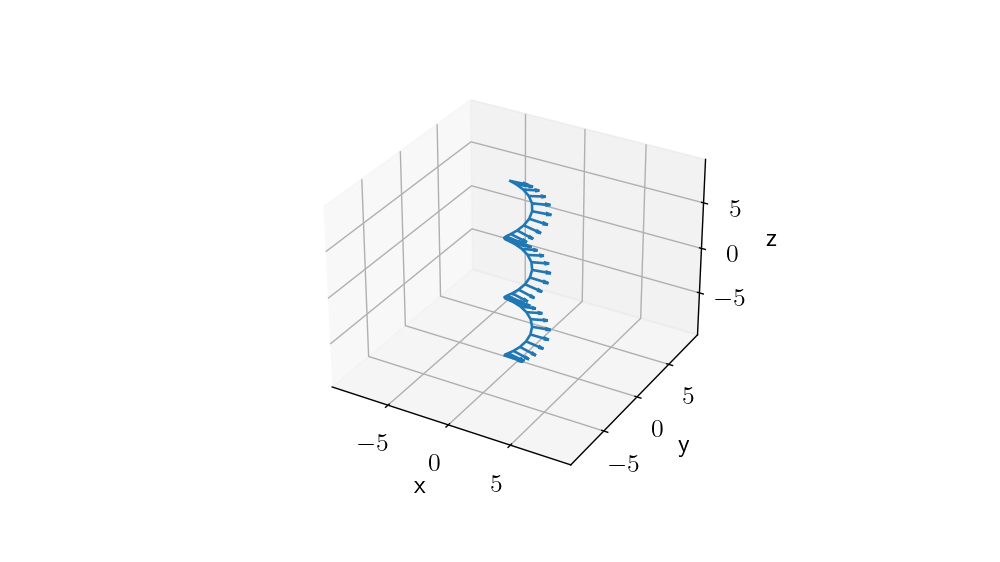

Text(0.5, 0, 'z')

In [108]:
%matplotlib notebook

plt.rcParams.update({'font.size': 15})
figsize=np.array((16, 9)) * 0.5
dpi = 50 if 'inline' in matplotlib.get_backend() else 100
quiver_each = 10

arc_x, arc_ft = wrapper_slice_ft(fgeo, f_tran_list[0][0], problem_kwargs)

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi, subplot_kw={'projection': '3d'})
fig.patch.set_facecolor('white')
tidx = (arc_x > ph * -1.5) * (arc_x < ph * 1.5)
for i0 in range(quiver_each - 1):
    tidx[i0::quiver_each] = False
axi.plot(*fgeo.axisNodes[tidx].T)
axi.quiver(*fgeo.axisNodes[tidx].T, *arc_ft[tidx, :3].T)
spf.set_axes_equal(axi)
axi.set_xlabel('x')
axi.set_ylabel('y')
axi.set_zlabel('z')


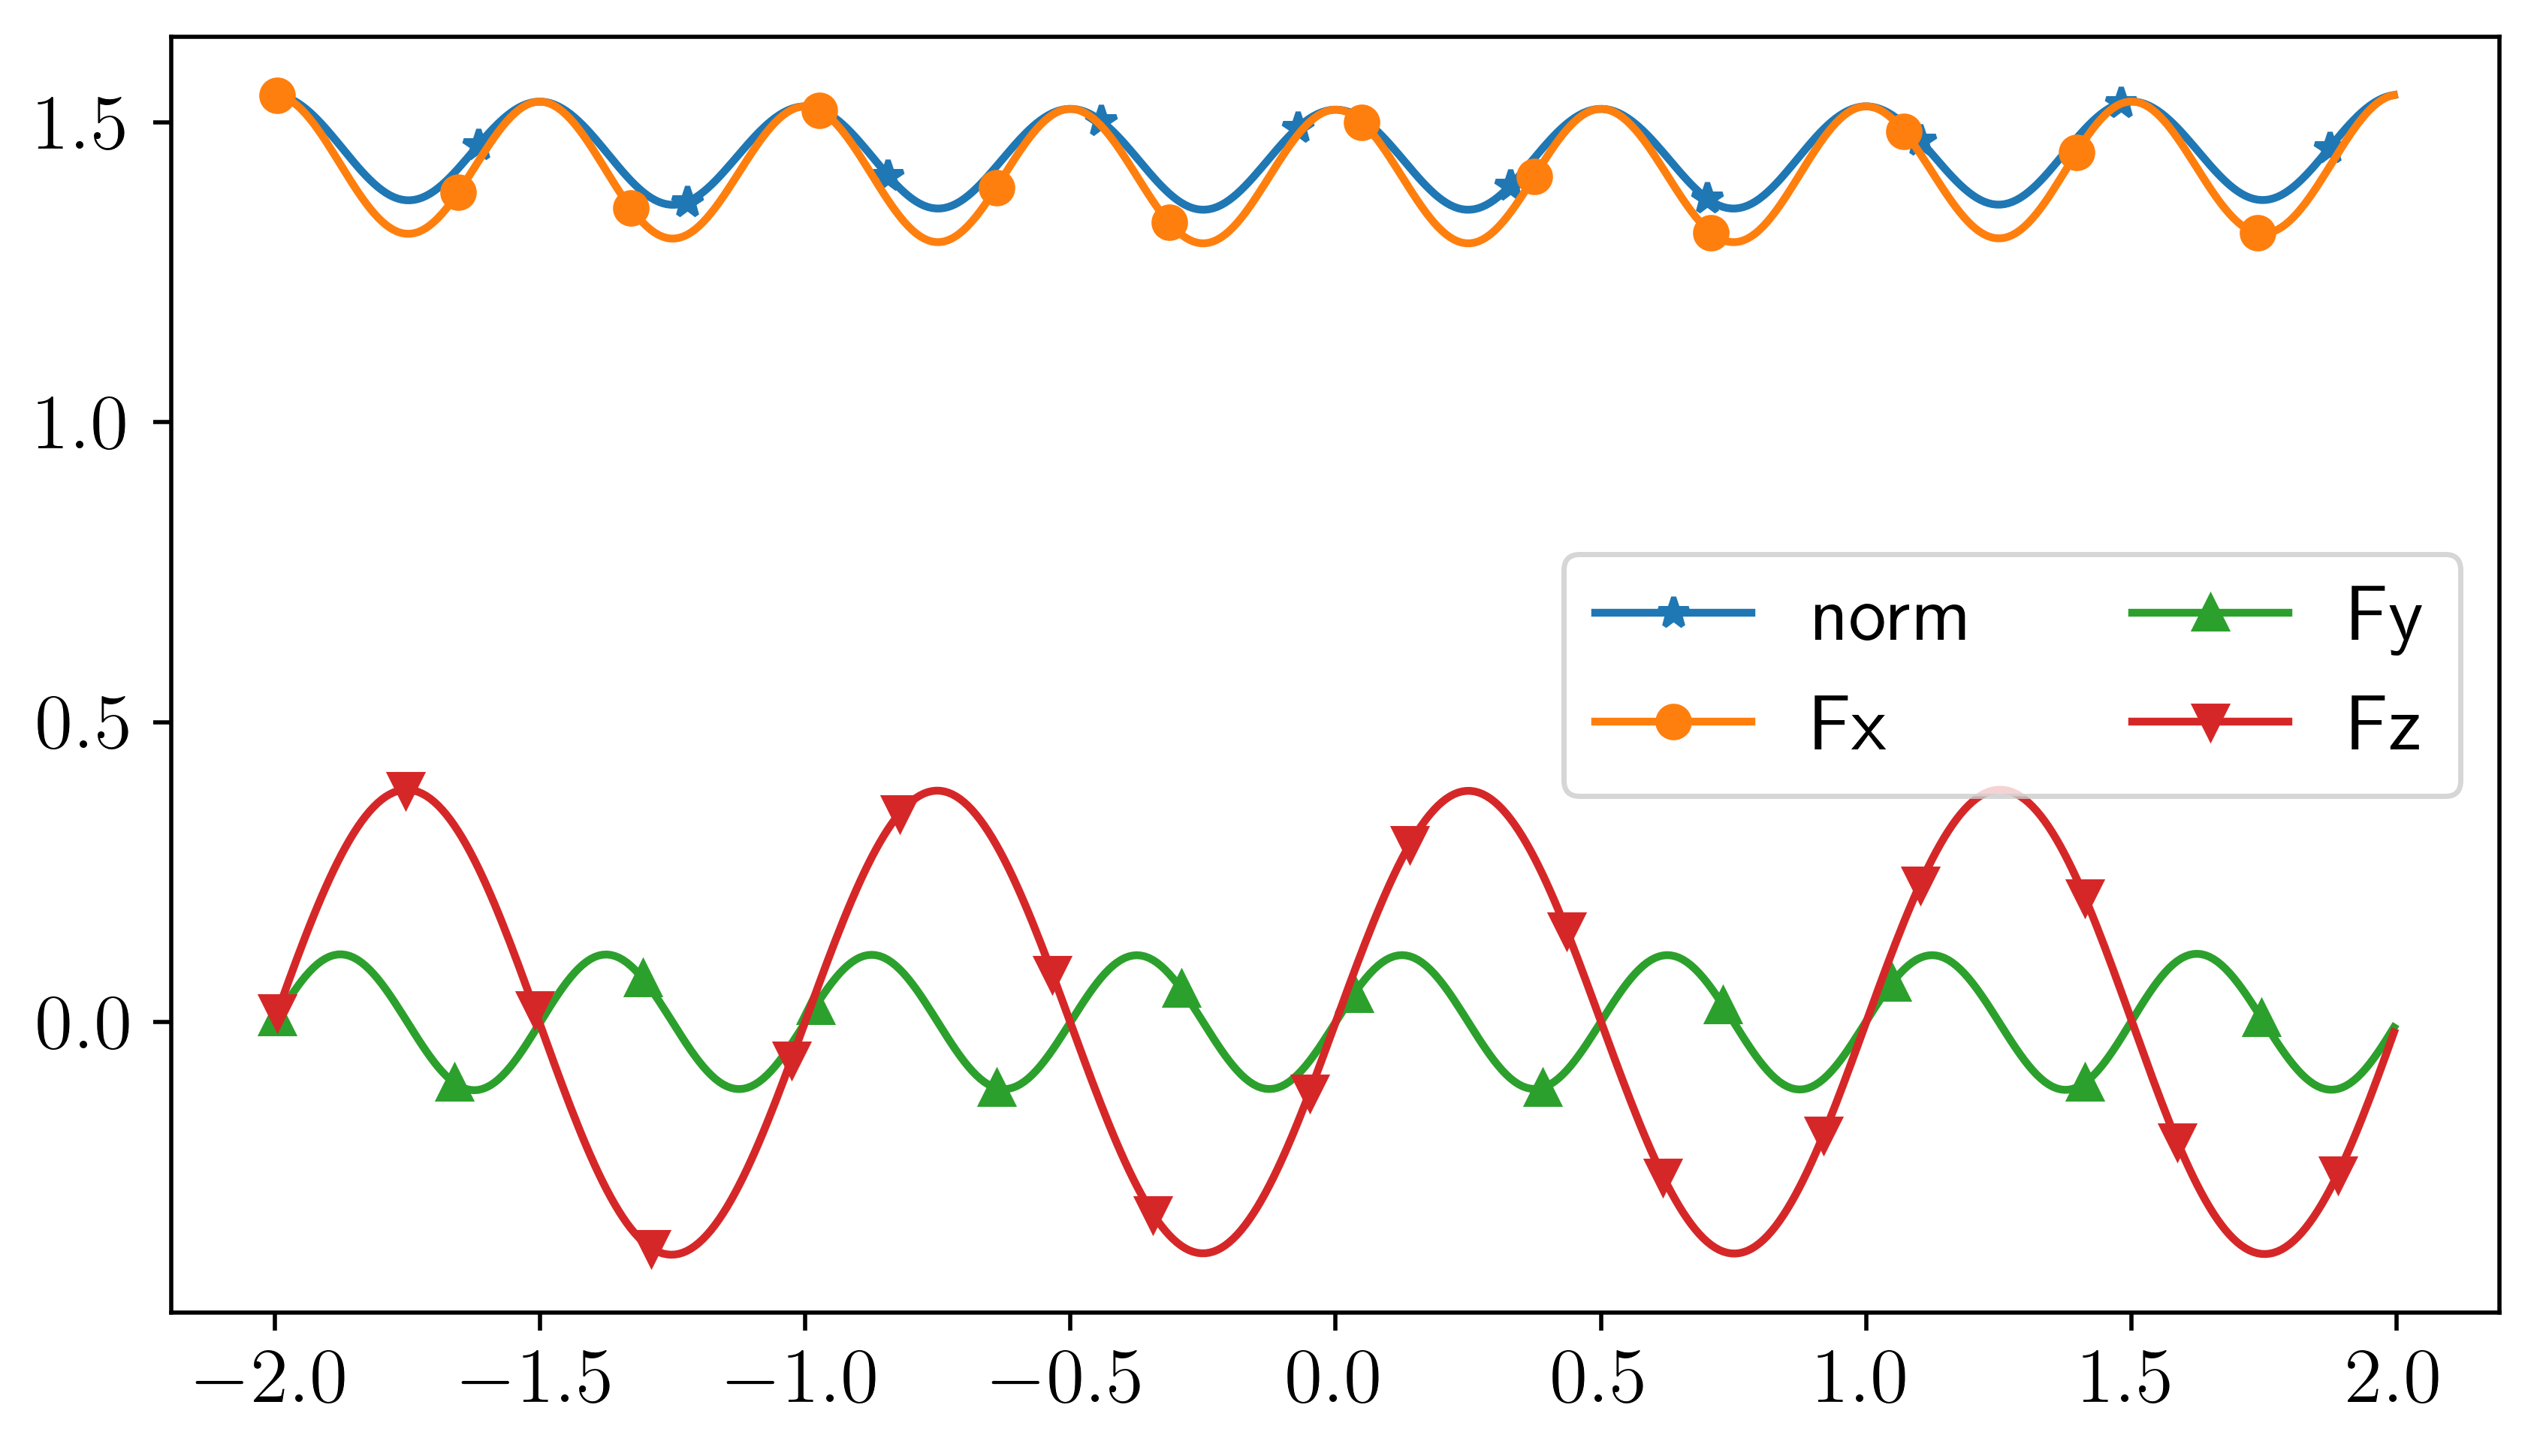

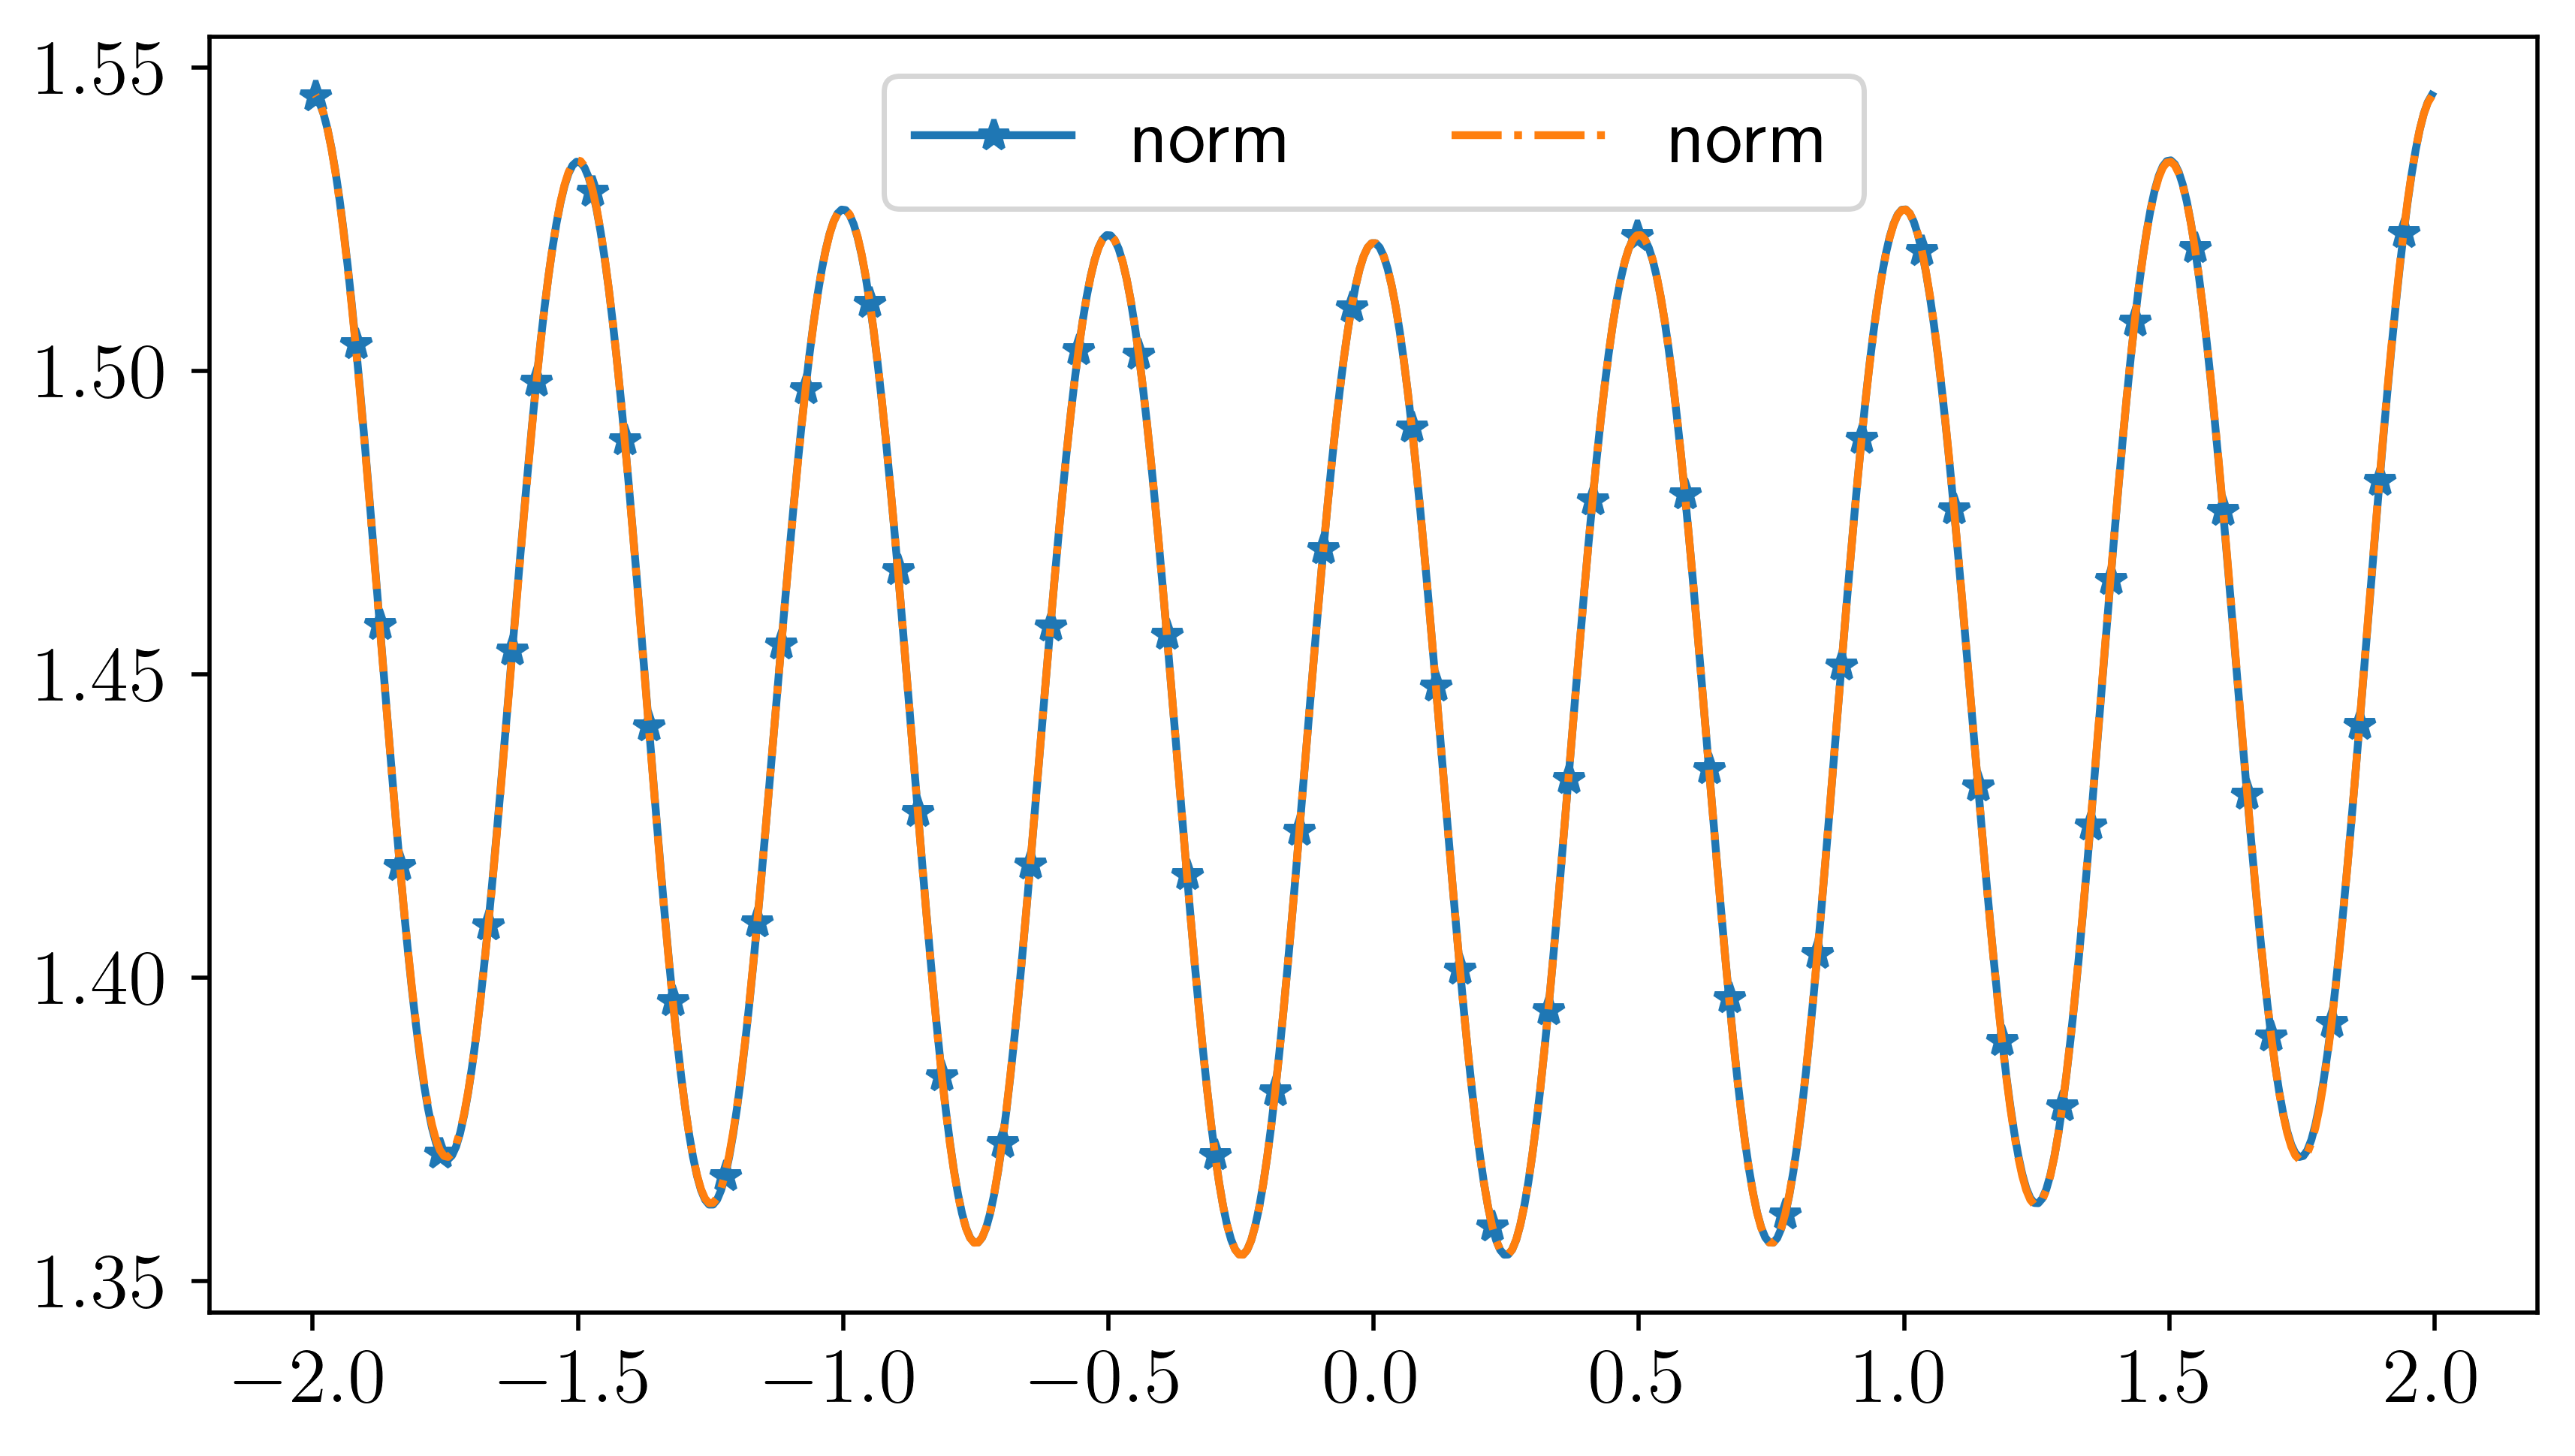

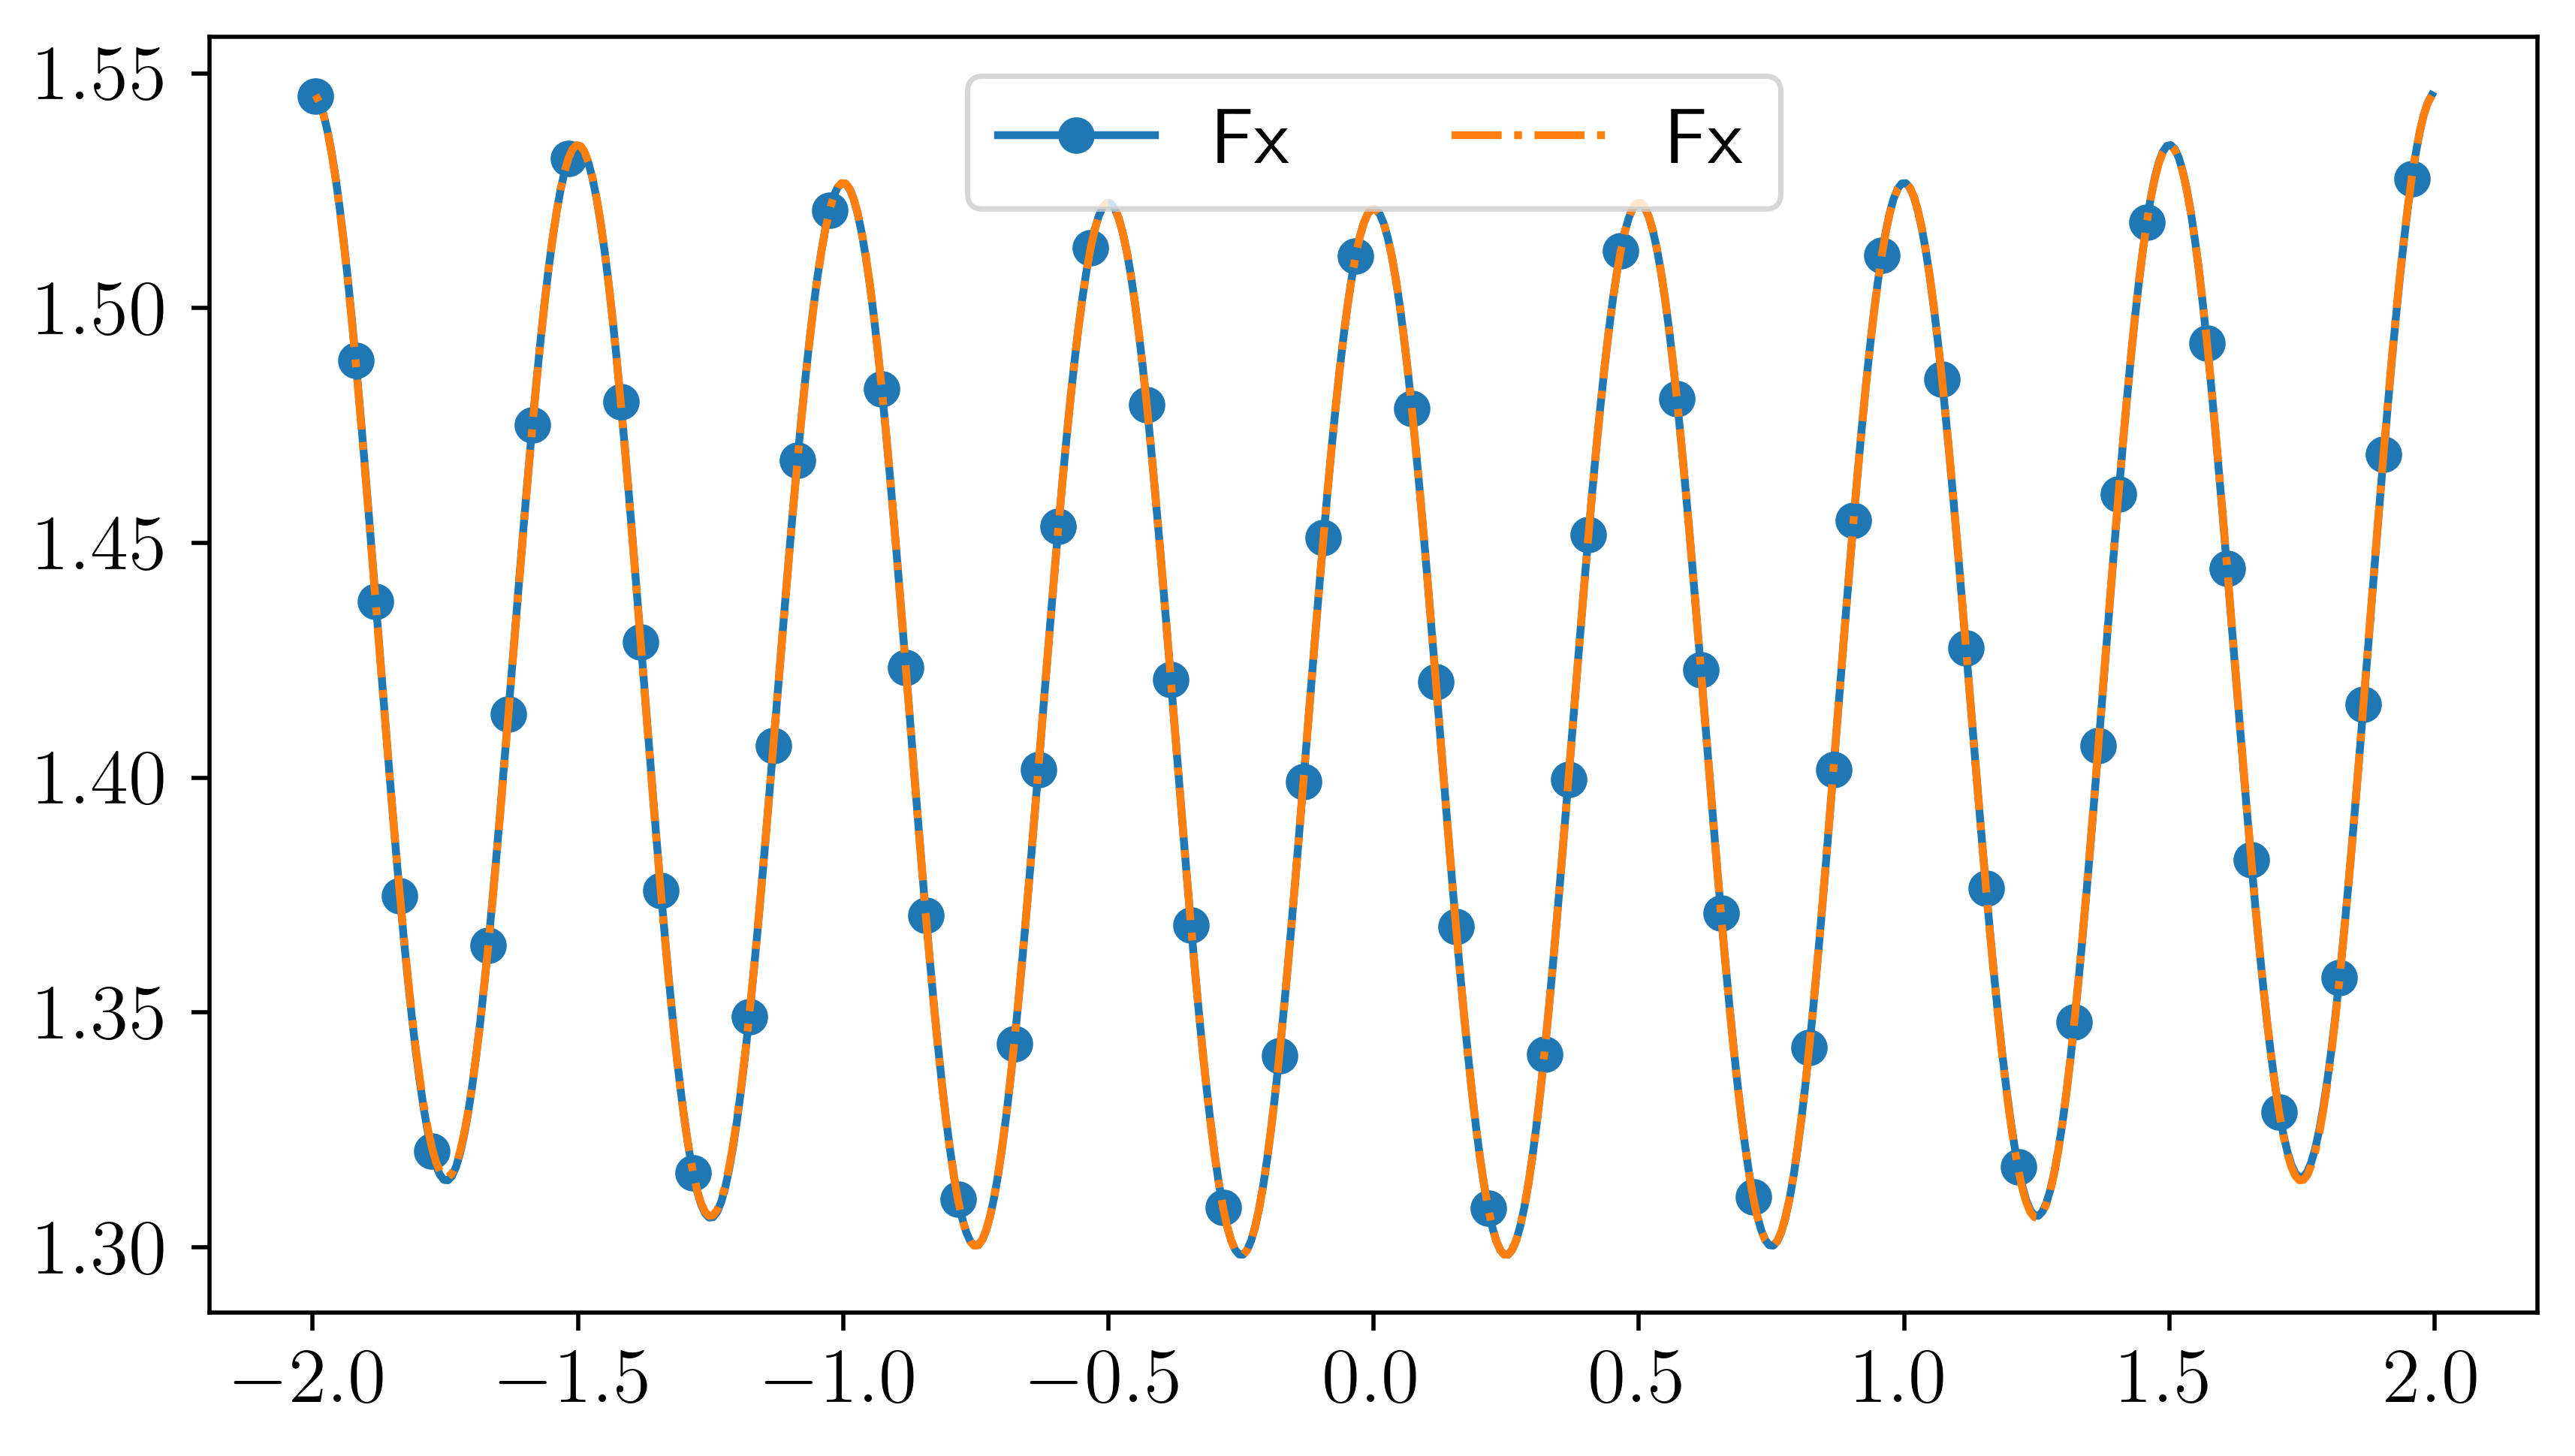

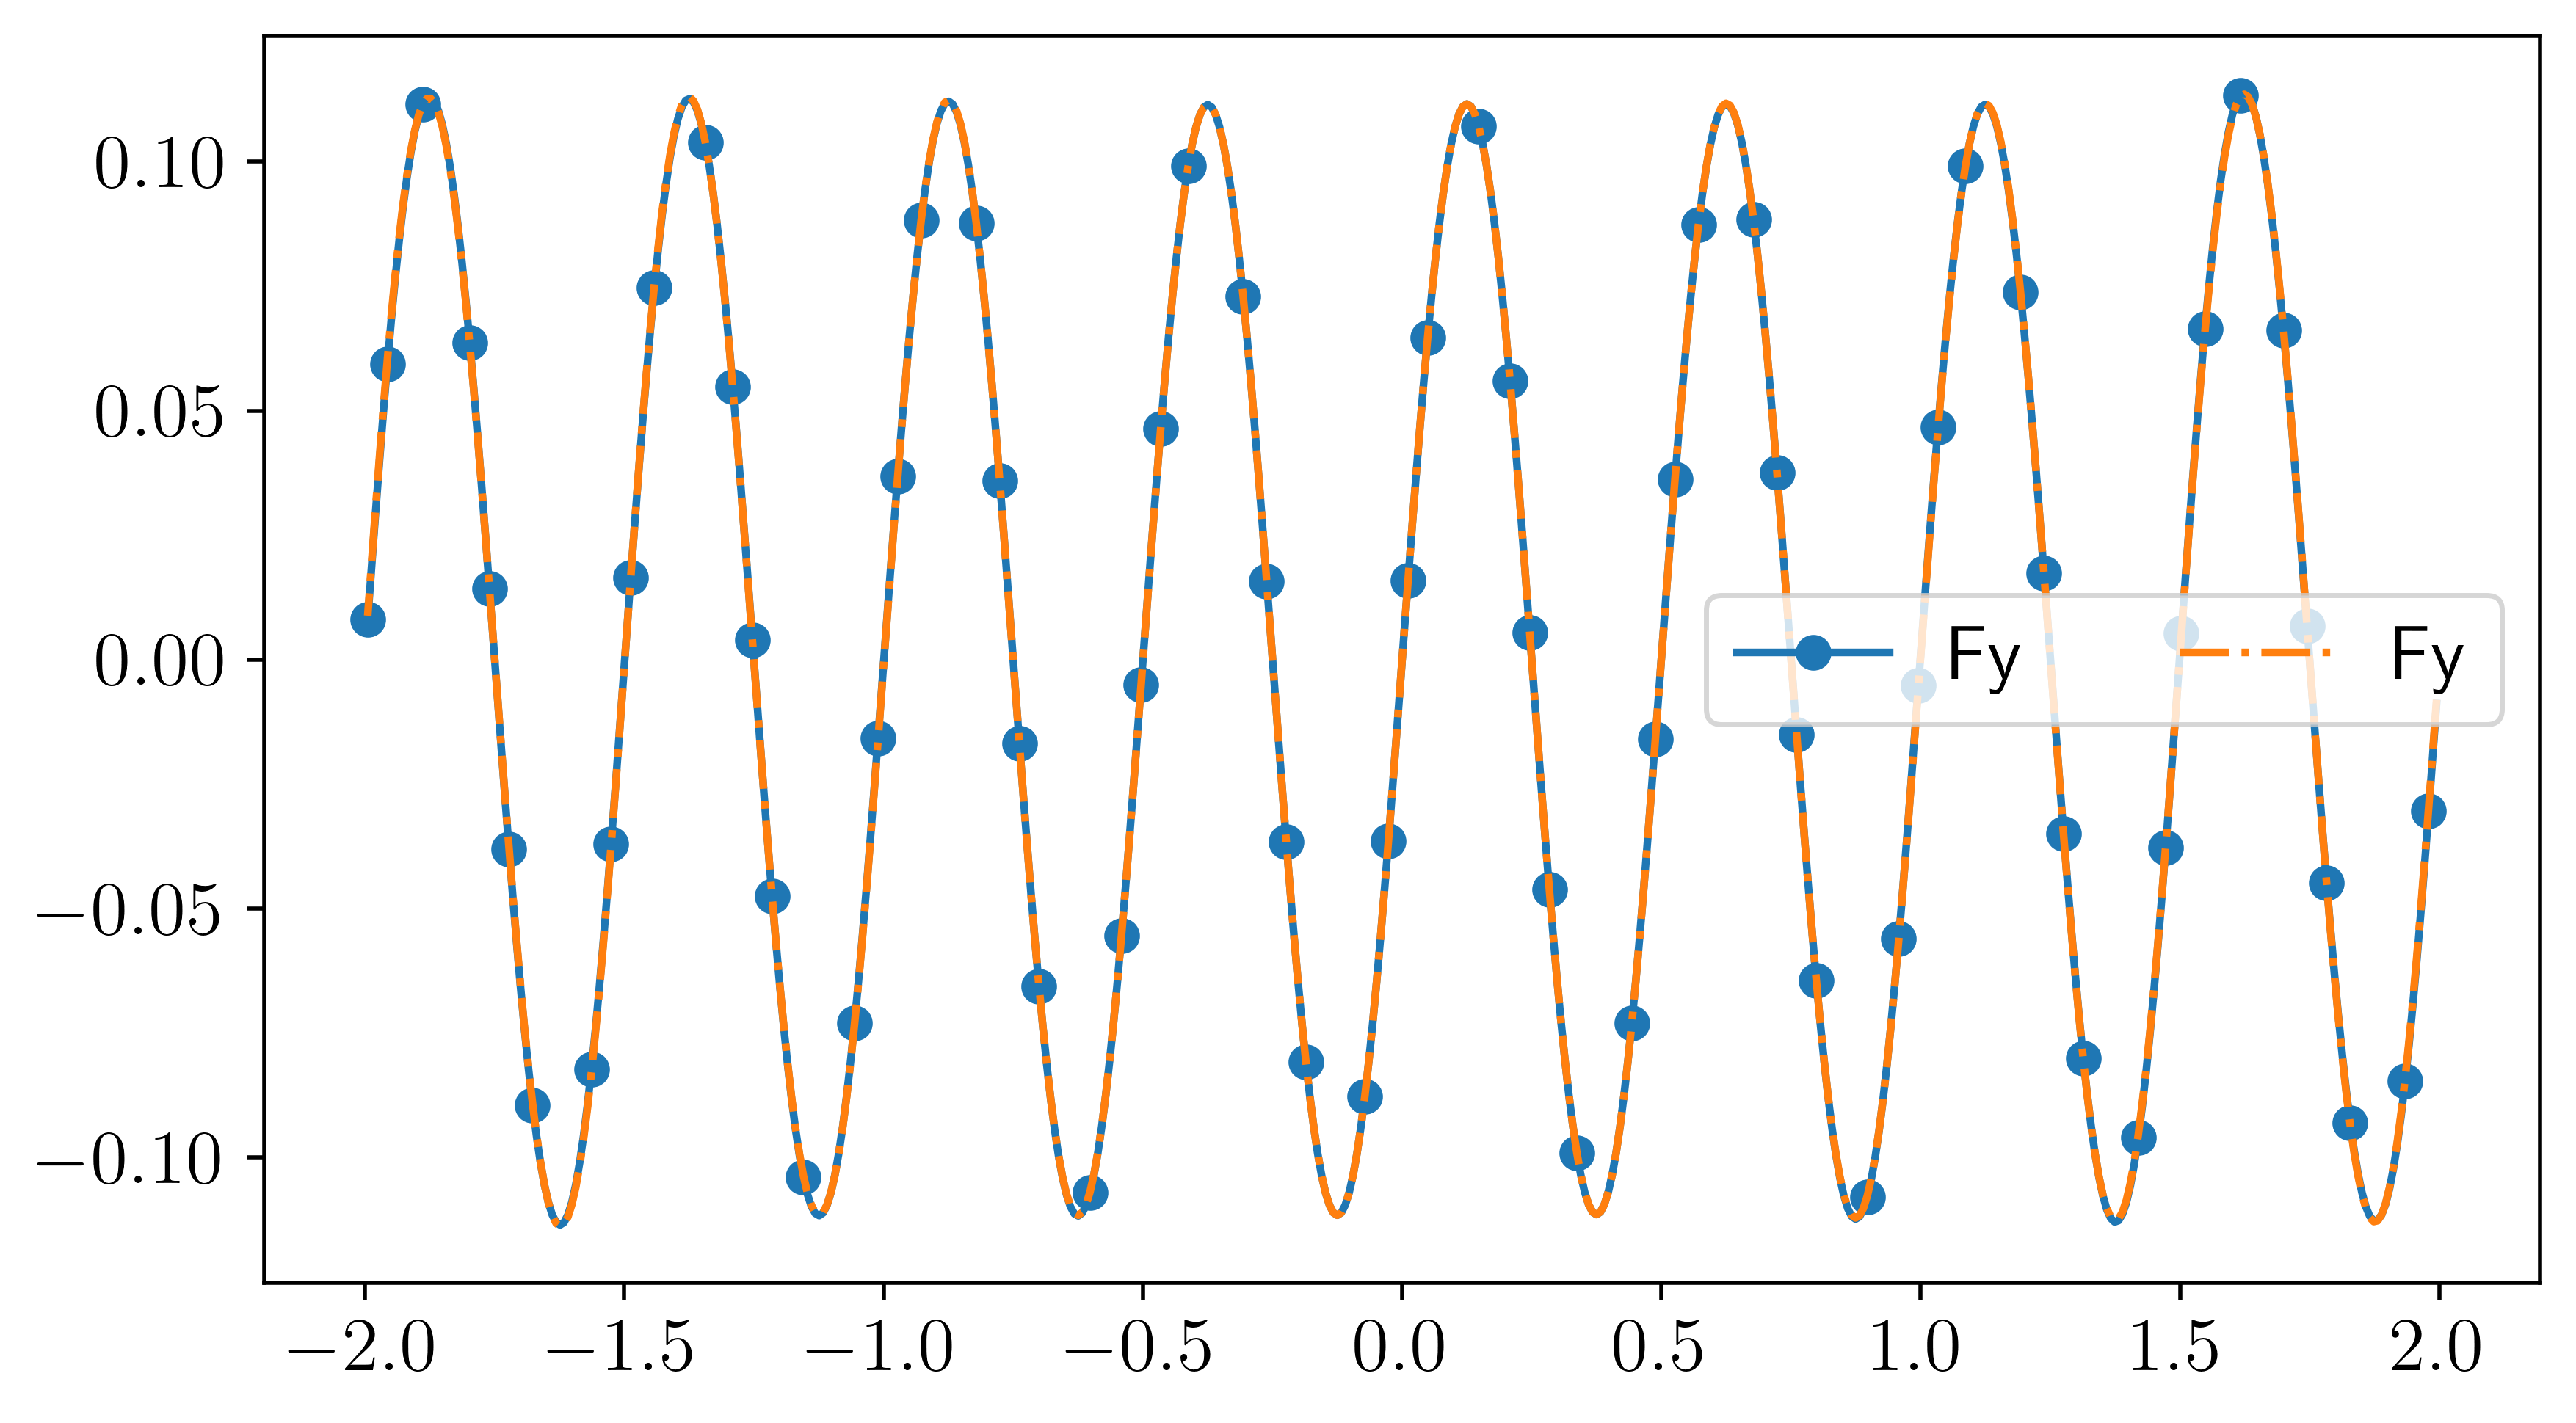

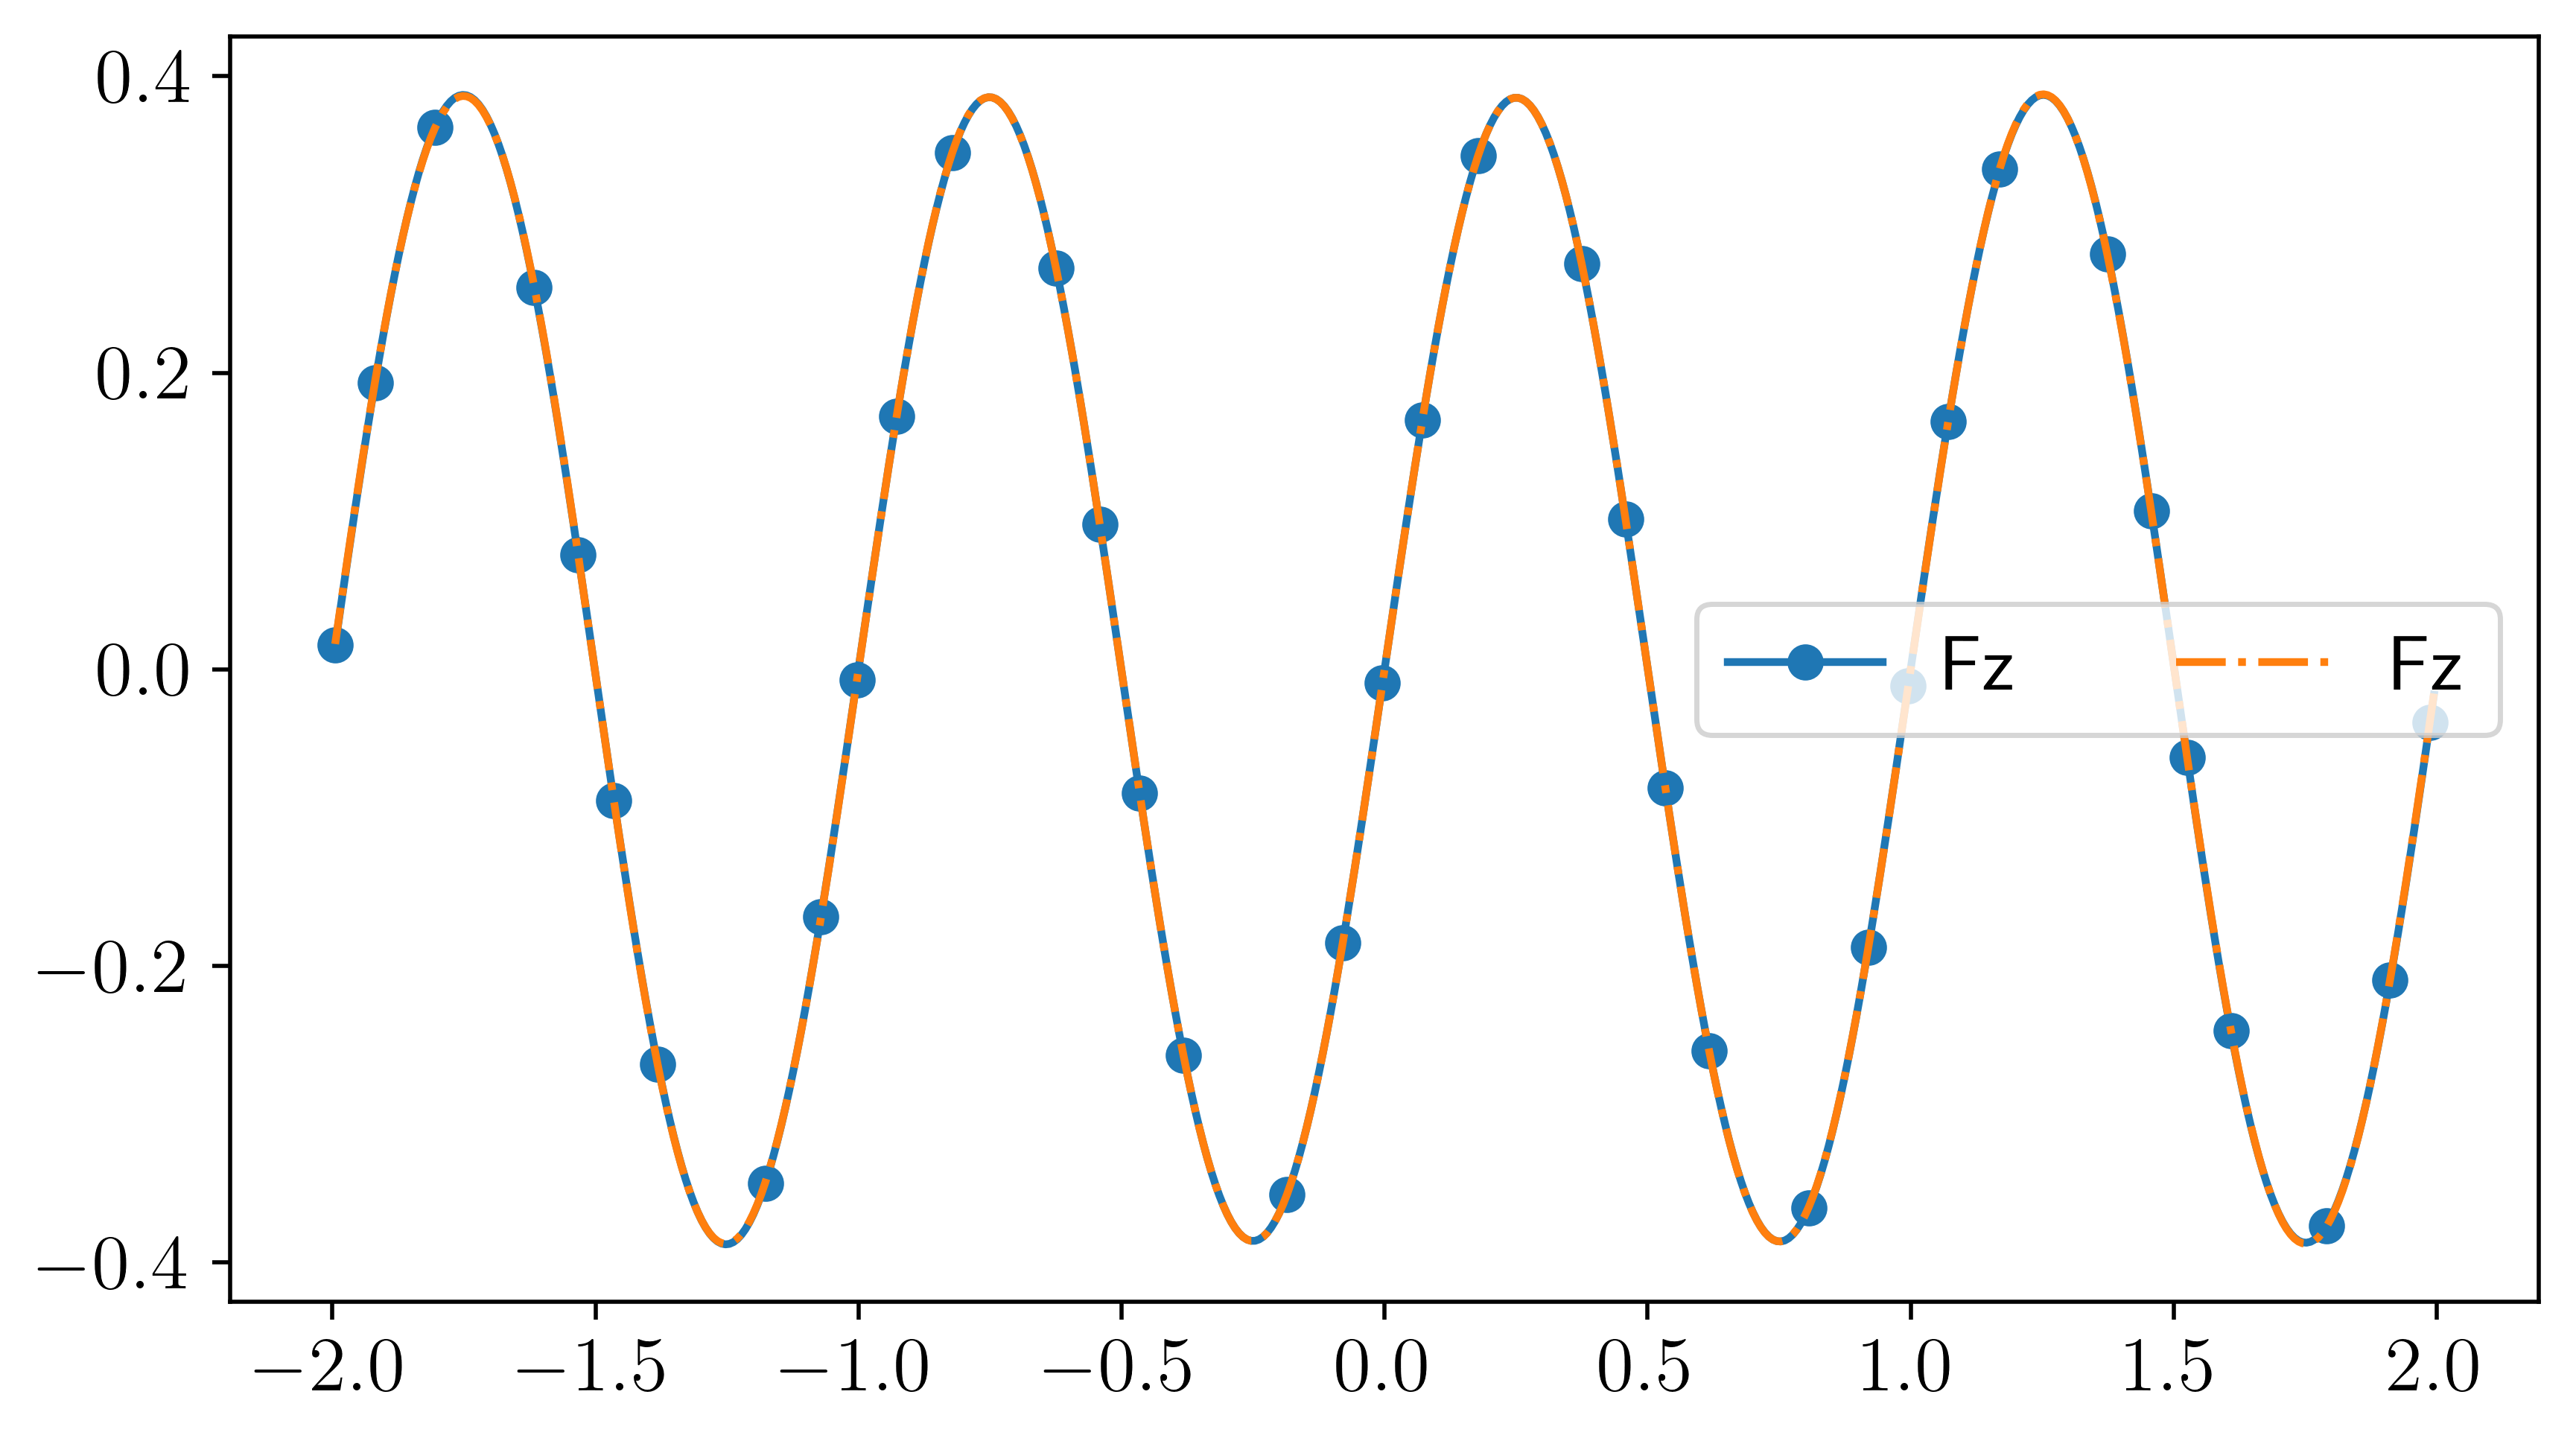

In [110]:
# %matplotlib notebook
%matplotlib inline

plt.rcParams.update({'font.size': 15})
figsize=np.array((16, 9)) * 0.5
dpi = 500 if 'inline' in matplotlib.get_backend() else 100

arc_x, arc_ft = wrapper_slice_ft(fgeo, f_tran_list[0][0], problem_kwargs)
tidx = (arc_x > ph * -2) * (arc_x < ph * 2)

# show all components 
fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi.plot(arc_x[tidx] / ph, np.linalg.norm(arc_ft[tidx, :3], axis=-1), '*-C0', markevery=0.1, label='norm')
axi.plot(arc_x[tidx] / ph, arc_ft[tidx, 0], 'o-C1', markevery=0.1, label='Fx')
axi.plot(arc_x[tidx] / ph, arc_ft[tidx, 1], '^-C2', markevery=0.1, label='Fy')
axi.plot(arc_x[tidx] / ph, arc_ft[tidx, 2], 'v-C3', markevery=0.1, label='Fz')
axi.legend(ncol=2)

# test symmetricity, norm
fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi.plot(arc_x[tidx] / ph, np.linalg.norm(arc_ft[tidx, :3], axis=-1), '*-C0', markevery=0.1, label='norm')
axi.plot(-arc_x[tidx] / ph, np.linalg.norm(arc_ft[tidx, :3], axis=-1), '-.C1', markevery=0.1, label='norm')
axi.legend(ncol=2)

# test symmetricity, Fx
fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi.plot(arc_x[tidx] / ph, arc_ft[tidx, 0], 'o-C0', markevery=0.1, label='Fx')
axi.plot(-arc_x[tidx] / ph, arc_ft[tidx, 0], '-.C1', markevery=0.1, label='Fx')
axi.legend(ncol=2)

# test symmetricity, Fy
fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi.plot(arc_x[tidx] / ph, arc_ft[tidx, 1], 'o-C0', markevery=0.1, label='Fy')
axi.plot(-arc_x[tidx] / ph, -arc_ft[tidx, 1], '-.C1', markevery=0.1, label='Fy')
axi.legend(ncol=2)

# test symmetricity, Fz
fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi.plot(arc_x[tidx] / ph, arc_ft[tidx, 2], 'o-C0', markevery=0.1, label='Fz')
axi.plot(-arc_x[tidx] / ph, -arc_ft[tidx, 2], '-.C1', markevery=0.1, label='Fz')
axi.legend(ncol=2)


fit_AFx [0.11214 1.41672]
fit_AFy [0.11228]
fit_AFz [0.38707]


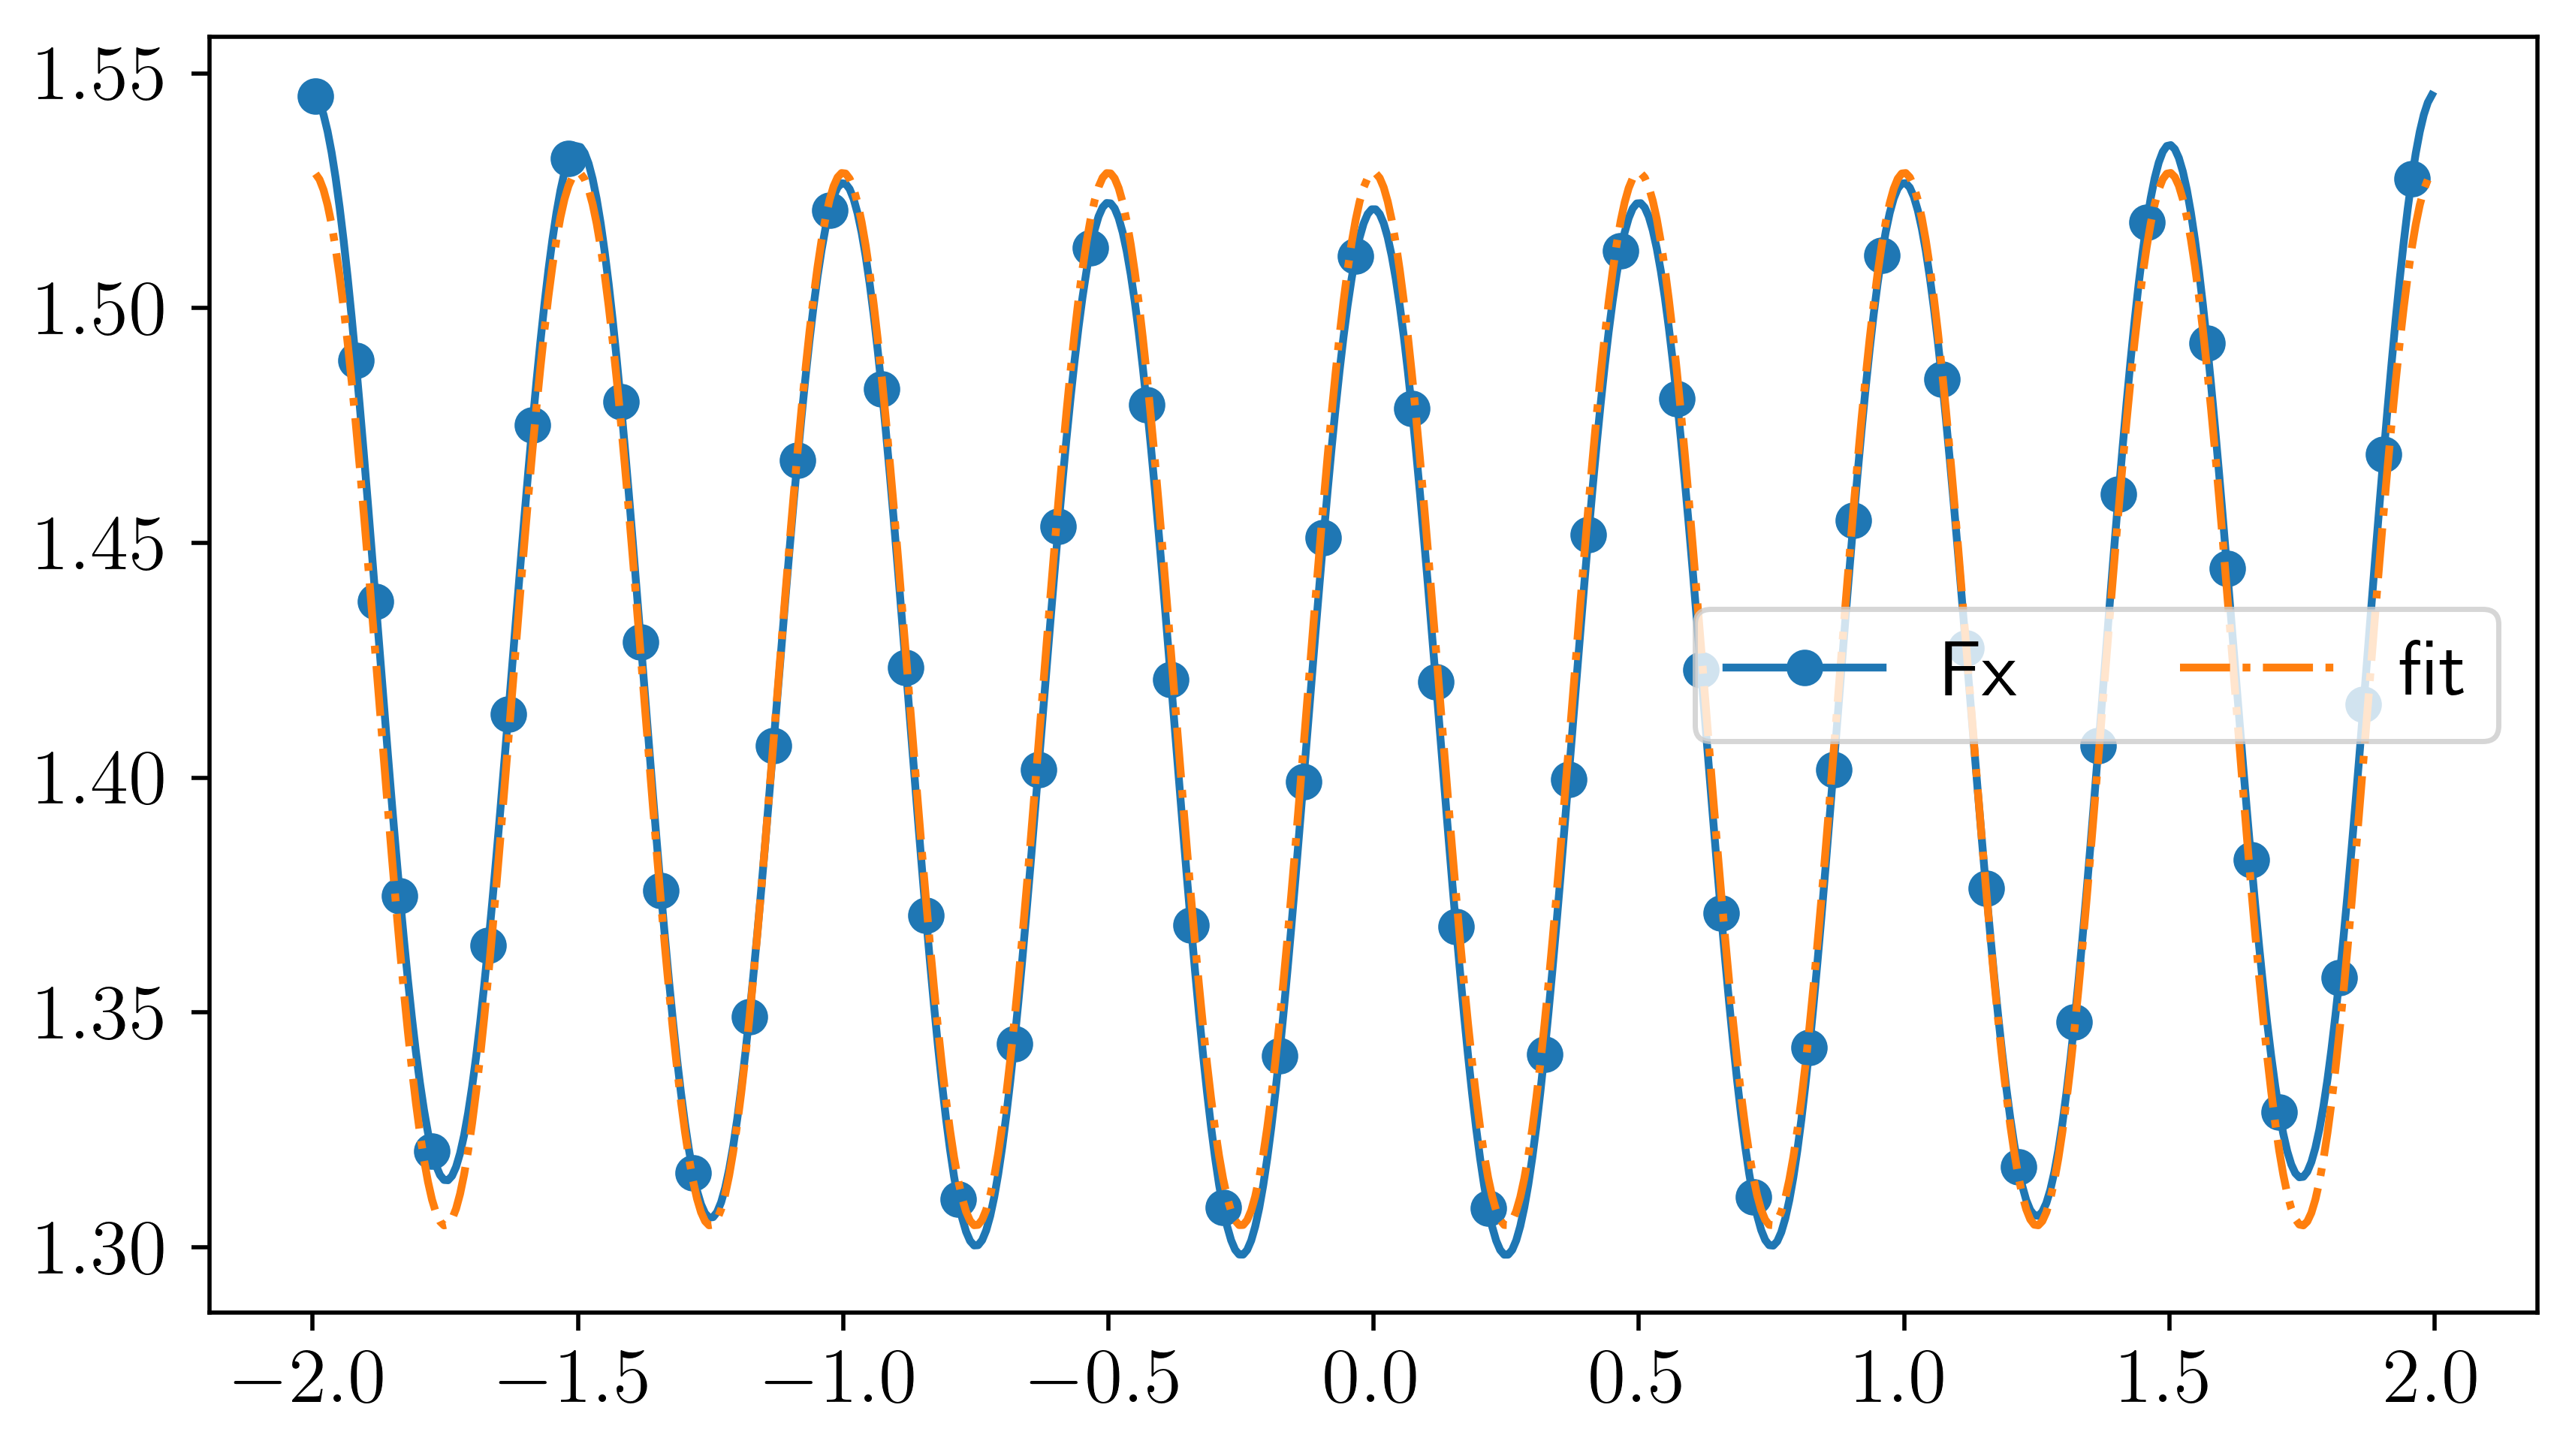

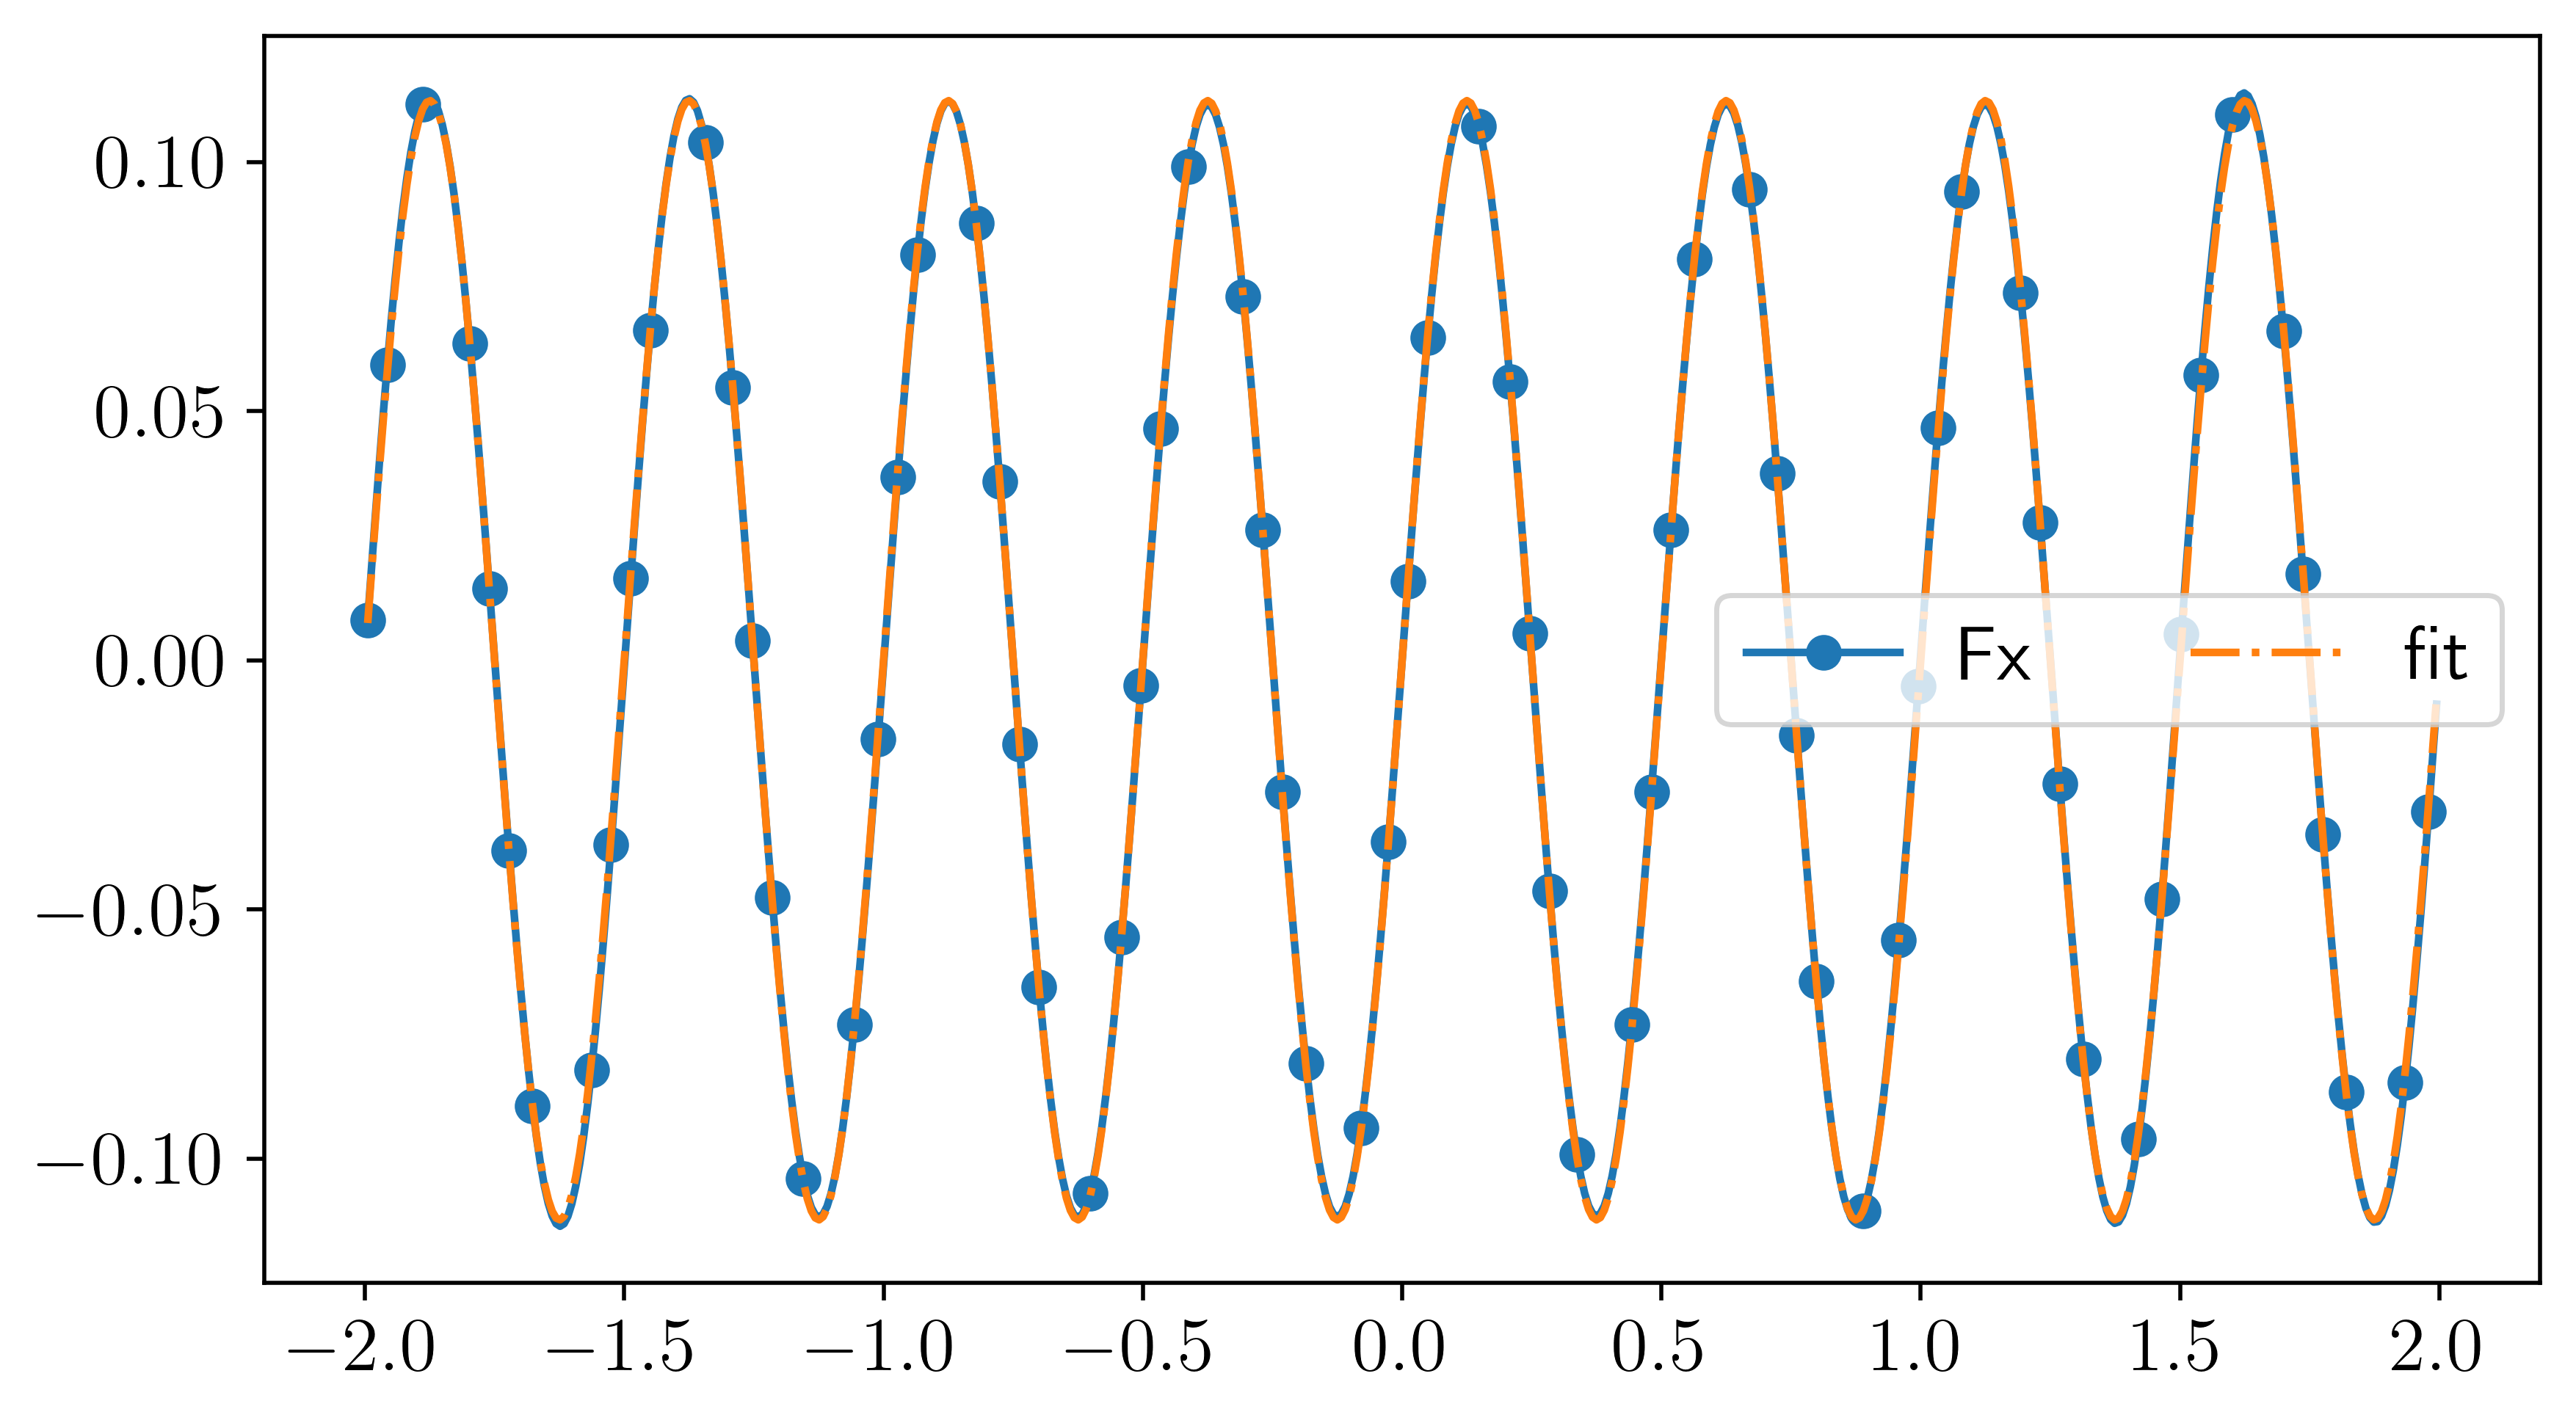

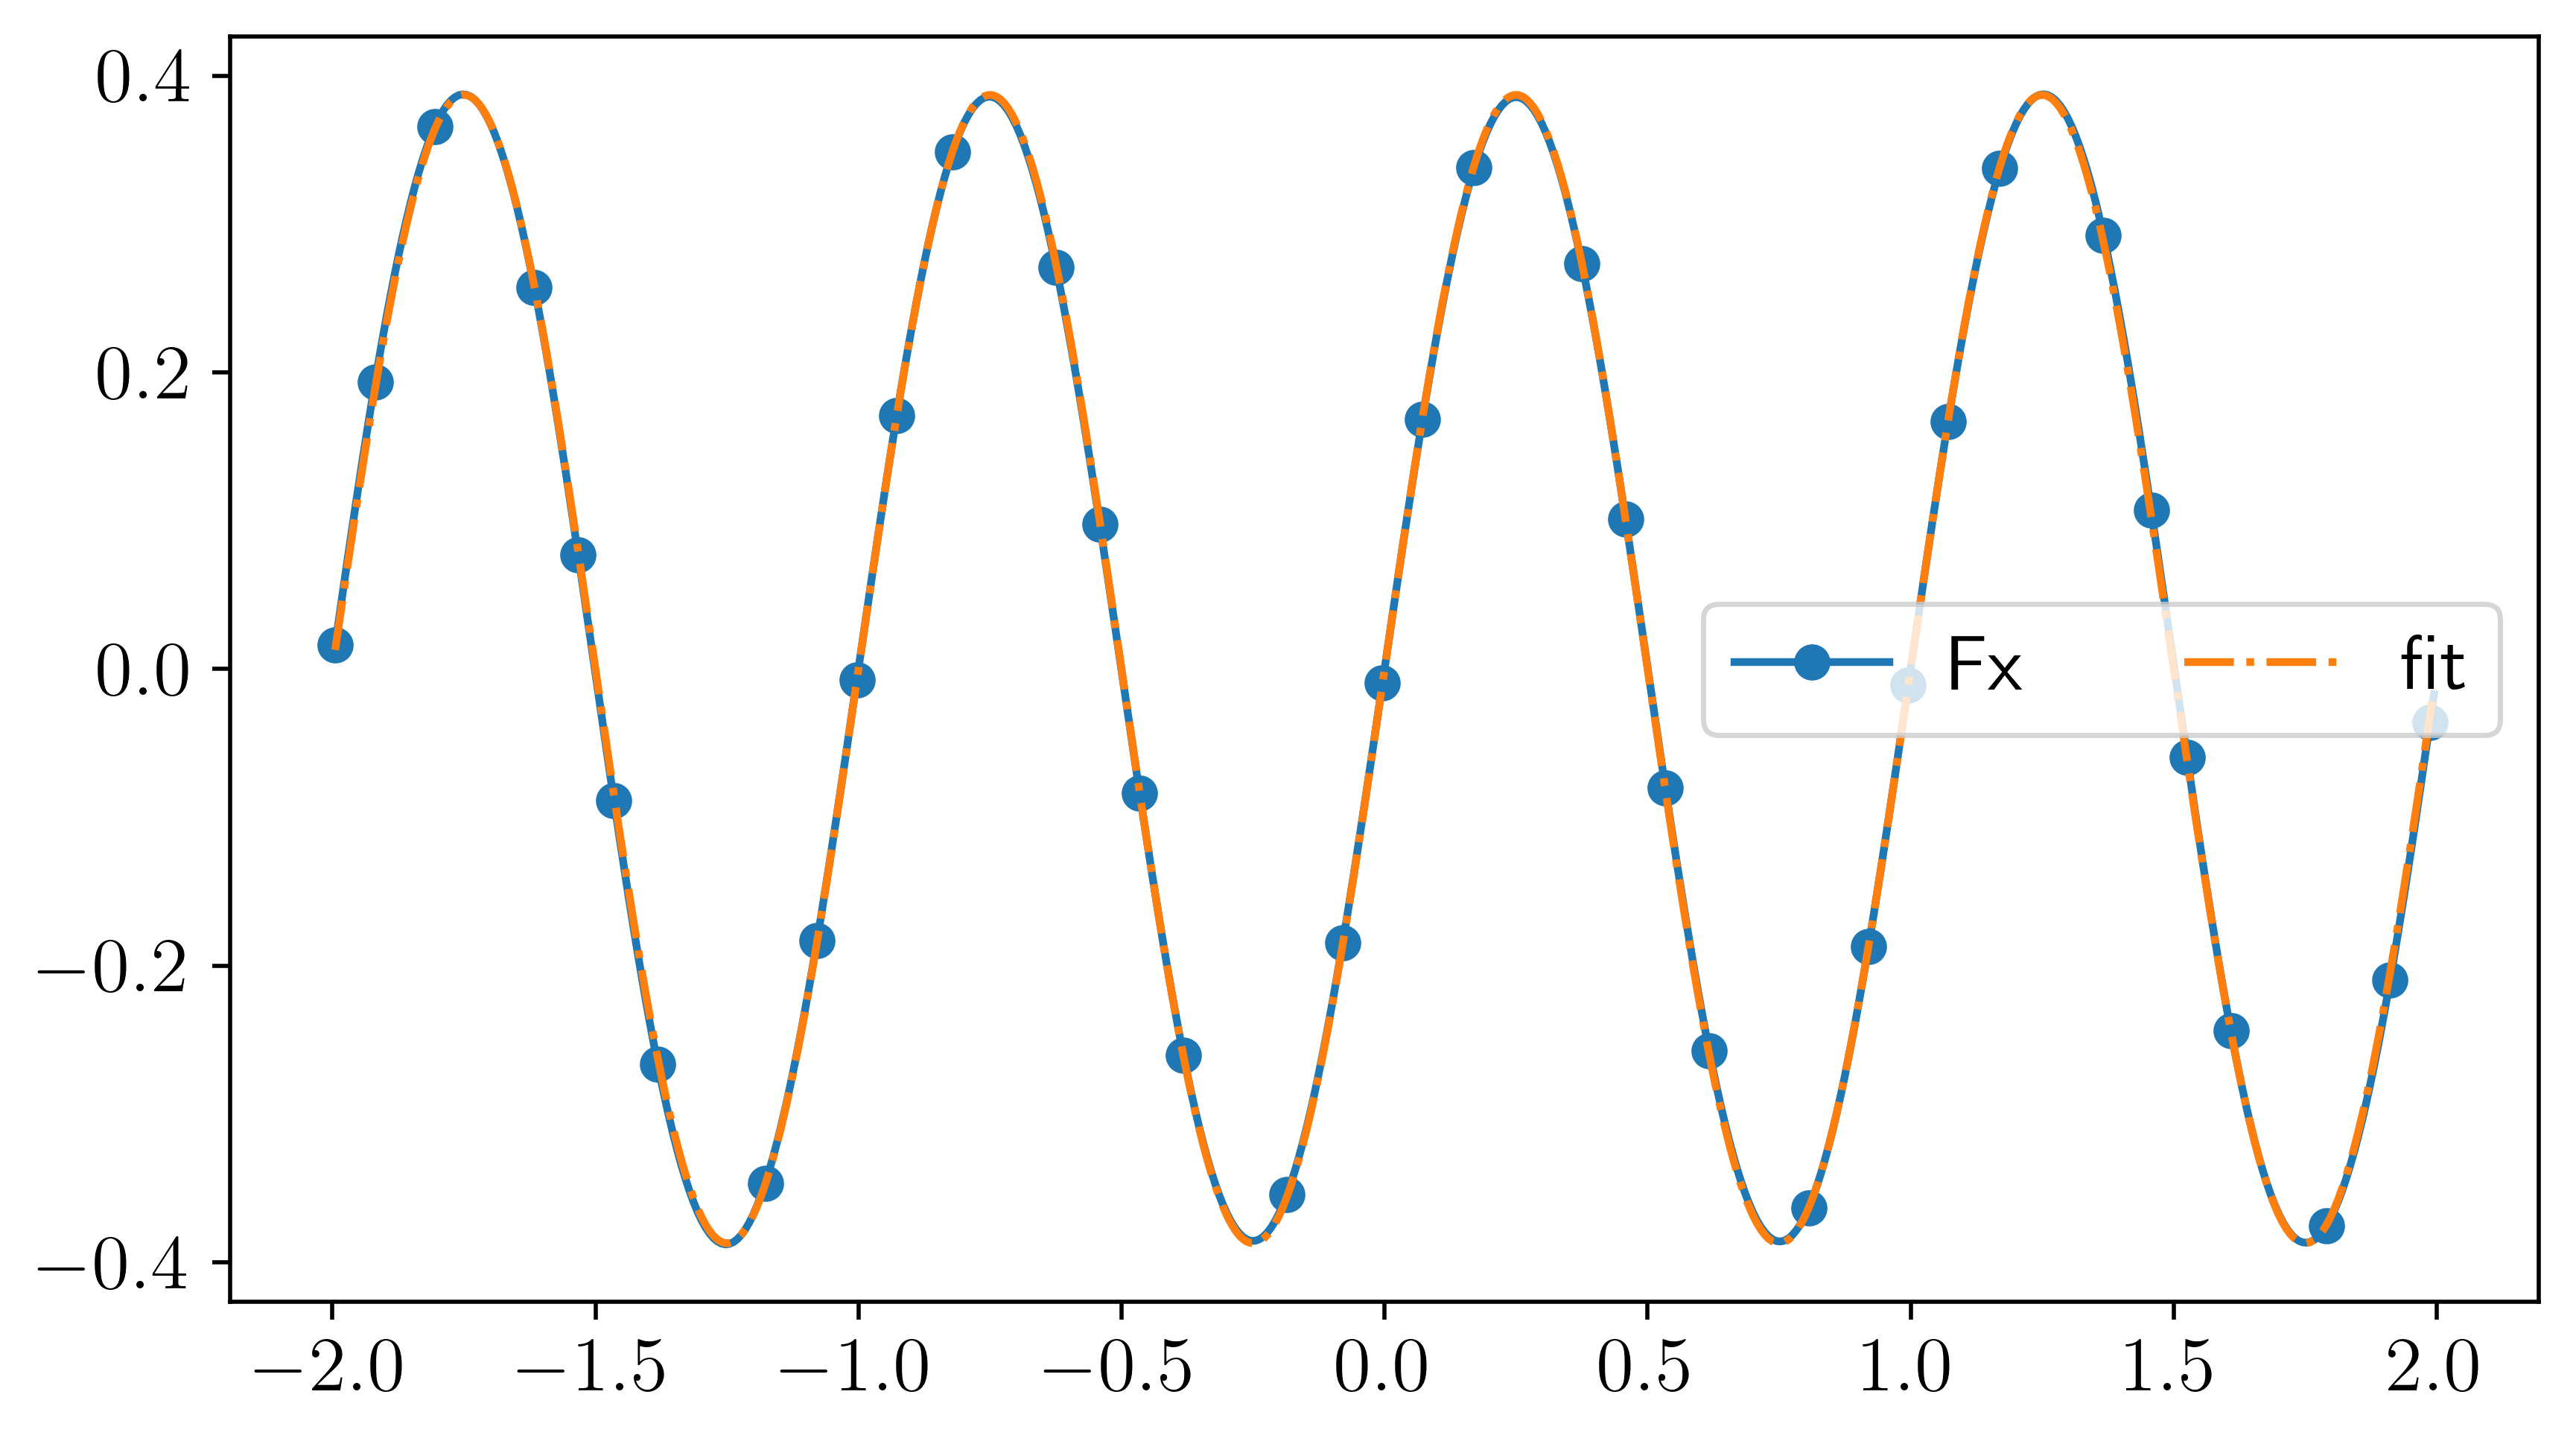

In [124]:
# %matplotlib notebook
%matplotlib inline

plt.rcParams.update({'font.size': 15})
figsize=np.array((16, 9)) * 0.5
dpi = 500 if 'inline' in matplotlib.get_backend() else 100

arc_x, arc_ft = wrapper_slice_ft(fgeo, f_tran_list[0][0], problem_kwargs)
tidx = (arc_x > ph * -2) * (arc_x < ph * 2)
tx = arc_x[tidx] / ph

################################################################################
# fit A, Fx
def func_AFx(x, a0, b):
    y = b + a0 * np.cos(4 * np.pi * x)
    return y

ty = arc_ft[tidx, 0]
p0 = [np.mean(ty), np.mean(np.abs(ty - np.mean(ty))), ]
fit_AFx, pcov = curve_fit(func_AFx, tx, ty, p0=p0)

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi.plot(tx, ty, 'o-C0', markevery=0.1, label='Fx')
axi.plot(tx, func_AFx(tx, *fit_AFx), '-.C1', markevery=0.1, label='fit')
axi.legend(ncol=2)
print('fit_AFx', fit_AFx)

################################################################################
# fit A, Fy
def func_AFy(x, a0):
    y = a0 * np.sin(4 * np.pi * x)
    return y

ty = arc_ft[tidx, 1]
p0 = [np.mean(np.abs(ty)), ]
fit_AFy, pcov = curve_fit(func_AFy, tx, ty, p0=p0)

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi.plot(tx, ty, 'o-C0', markevery=0.1, label='Fx')
axi.plot(tx, func_AFy(tx, *fit_AFy), '-.C1', markevery=0.1, label='fit')
axi.legend(ncol=2)
print('fit_AFy', fit_AFy)

################################################################################
# fit A, Fz
def func_AFz(x, a0):
    y = a0 * np.sin(2 * np.pi * x)
    return y

ty = arc_ft[tidx, 2]
p0 = [np.mean(np.abs(ty)), ]
fit_AFz, pcov = curve_fit(func_AFz, tx, ty, p0=p0)

fig, axi = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi.plot(tx, ty, 'o-C0', markevery=0.1, label='Fx')
axi.plot(tx, func_AFz(tx, *fit_AFz), '-.C1', markevery=0.1, label='fit')
axi.legend(ncol=2)
print('fit_AFz', fit_AFz)
